# Initialize data, load packages and needed modules

In [1]:
random_seeds = [42, 100, 0, 10, 12, 20, 50, 9, 30, 51]
run = 0

In [2]:
username = 'meganorm-yverduyn'
datasets = {
    'TDBrain': {''
        'base_dir': '/project/meganorm/Data/EEG_TDBrain/EEG/', #Final
        #'base_dir': '/home/meganorm-yverduyn/Dev/BIDS_TDBrain',  #To test 
        'task': 'task-restEC', 
        'ending': 'eeg.vhdr'
    },

    'MIPDB': {
        'base_dir': '/project/meganorm/Data/EEG_MIPDB/EEG_BIDS/', #Final
        #'base_dir': '/home/meganorm-yverduyn/Dev/MIPDB/EEG_BIDS',  #To test 
        'task': 'task-eyesclosed', 
        'ending': 'eeg.set'
},

    'CMI': {
        'base_dir': '/project/meganorm/Data/EEG_CMI/EEG_BIDS', #Final
        #'base_dir': '/home/meganorm-yverduyn/Dev/BIDS_CMI',  #To test 
        'task': 'task-eyesclosed', 
        'ending': 'eeg.set'
    }
    }

package_path = f'/home/{username}/Code/MEGaNorm/'

In [3]:
import os
os.chdir(package_path)
from utils.parallel import submit_jobs, check_jobs_status, collect_results
from utils.nm import hbr_data_split, estimate_centiles, abnormal_probability, prepare_prediction_data, aggregate_metrics_across_runs, cal_stats_for_gauge
from plots.plots import plot_nm_range_site2, plot_age_dist2, box_plot_auc, plot_metrics, z_scores_scatter_plot, plot_quantile_gauge
from utils.IO import merge_fidp_demo, merge_datasets_with_glob
from datasets.mne_bids_conversion import make_demo_file_bids
import pandas as pd
import json
from pcntoolkit.normative_parallel import execute_nm
import warnings
import numpy as np
from pcntoolkit.util.utils import z_to_abnormal_p, anomaly_detection_auc
from scipy.stats import false_discovery_control
import pickle 
warnings.filterwarnings("ignore")

# Create configuration file

In [4]:
def make_config(project, path=None):

    # preprocess configurations =================================================
    # downsample data
    config = dict()

    # You could also set layout to None to have high 
    # choices: all, lobe, None
    config["which_layout"] = "all"

    # which sensor type should be used
    # choices: meg, mag, grad, eeg, opm
    config["which_sensor"] = "eeg"
    # config['fs'] = 500

    # ICA configuration
    config['ica_n_component'] = 25
    config['ica_max_iter'] = 800
    config['ica_method'] = "infomax" 

    # lower and upper cutoff frequencies in a bandpass filter
    config['cutoffFreqLow'] = 1
    config['cutoffFreqHigh'] = 45

    config["resampling_rate"] = 1000
    config["digital_filter"] = True
    config["notch_filter"] = False

    config["apply_ica"] = True

    config["auto_ica_corr_thr"] = 0.8

    config["rereference_method"]= "average"
    
    # variance threshold across time
    config["mag_var_threshold"] = 4e-12
    config["grad_var_threshold"] = 4000e-13
    config["eeg_var_threshold"] = 40e-6  
    # flatness threshold across time
    config["mag_flat_threshold"] = 10e-15
    config["grad_flat_threshold"] = 10e-15
    config["eeg_flat_threshold"] = 10e-6 

    # segmentation ==============================================
    #start time of the raw data to use in seconds, this is to avoid possible eye blinks in close-eyed resting state. 
    config['segments_tmin'] = 5
    # end time of the raw data to use in seconds, this is to avoid possible eye blinks in close-eyed resting state.
    config['segments_tmax'] = -5
    # length of EEG segments in seconds
    config['segments_length'] = 10
    # amount of overlap between EEG sigals in seconds
    config['segments_overlap'] = 2

    # PSD ==============================================
    # Spectral estimation method
    config['psd_method'] = "welch"
    # amount of overlap between windows in Welch's method
    config['psd_n_overlap'] = 1
    config['psd_n_fft'] = 2
    # number of samples in psd
    config["psd_n_per_seg"] = 2

    # fooof analysis configurations ==============================================
    # Desired frequency range to run FOOOF
    config['fooof_freqRangeLow'] = 3
    config['fooof_freqRangeHigh'] = 40
    # which mode should be used for fitting; choices (knee, fixed)
    config["aperiodic_mode"] = "knee"
    # minimum acceptable peak width in fooof analysis
    config["fooof_peak_width_limits"] = [1.0, 12.0]
    #Absolute threshold for detecting peaks
    config['fooof_min_peak_height'] = 0
    #Relative threshold for detecting peaks
    config['fooof_peak_threshold'] = 2

    # feature extraction ==========================================================
    # Define frequency bands
    config['freq_bands'] = {
                            'Theta': (3, 8),
                            'Alpha': (8, 13),
                            'Beta': (13, 30),
                            'Gamma': (30, 40),
                            # 'Broadband': (3, 40)
                            }

    # Define individualized frequency range over main peaks in each freq band
    config['individualized_band_ranges'] = { 
                                            'Theta': (-2, 3),
                                            'Alpha': (-2, 3), # change to (-4,2)
                                            'Beta': (-8, 9),
                                            'Gamma': (-5, 5)
                                            }

    # least acceptable R squred of fitted models
    config['min_r_squared'] = 0.9 
 
    config['feature_categories'] = {
                                    "Offset":False,
                                    "Exponent":False,
                                    "Peak_Center":False,
                                    "Peak_Power":False,
                                    "Peak_Width":False,
                                    "Adjusted_Canonical_Relative_Power":True, 
                                    "Adjusted_Canonical_Absolute_Power":False,
                                    "Adjusted_Individualized_Relative_Power":False,
                                    "Adjusted_Individualized_Absolute_Power":False,
                                    "OriginalPSD_Canonical_Relative_Power":False, 
                                    "OriginalPSD_Canonical_Absolute_Power":False,
                                    "OriginalPSD_Individualized_Relative_Power":False,
                                    "OriginalPSD_Individualized_Absolute_Power":False,
                                    }
    
    config["fooof_res_save_path"] = None

    config["random_state"] = 97#change? 

    if path is not None:
        out_file = open(os.path.join(path, project + ".json"), "w") 
        json.dump(config, out_file, indent = 6) 
        out_file.close()

    return config

# Define directories and job specifications needed for feature extraction and NM, merge datasets

In [5]:
project = "Thesis_learning_disorder"

project_dir = f'/home/{username}/Results/{project}/'

mainParallel_path = os.path.join(package_path, 'src', 'mainParallel.py')

features_dir = os.path.join(project_dir, 'Features')
features_log_path = os.path.join(features_dir, 'log')
features_temp_path = os.path.join(features_dir,'temp')
pics_dir = os.path.join(project_dir, "pics")

nm_processing_dir = os.path.join(project_dir, 'NM', 'Run_' + str(run))

job_configs = {'log_path':features_log_path, 'module':'mne', 'time':'1:00:00', 'memory':'20GB', 
                'partition':'normal', 'core':1, 'node':1, 'batch_file_name':'batch_job'}

if not os.path.isdir(features_log_path):
    os.makedirs(features_log_path)

if not os.path.isdir(features_temp_path):
    os.makedirs(features_temp_path)
    
if not os.path.isdir(nm_processing_dir):
    os.makedirs(nm_processing_dir)

if not os.path.isdir(pics_dir):
    os.makedirs(pics_dir)
    
configs = make_config(project, project_dir)

subjects = merge_datasets_with_glob(datasets)


# f-IDPs Extraction

In [ ]:
### Parallel feature extraction  

# # Running Jobs
start_time = submit_jobs(mainParallel_path, features_dir, subjects, 
                features_temp_path, job_configs=job_configs, config_file=os.path.join(project_dir, project+'.json'))
# Checking jobs
failed_jobs = check_jobs_status(username, start_time)

falied_subjects = {failed_job:subjects[failed_job] for failed_job in failed_jobs}

while len(failed_jobs)>0:
    # Re-running Jobs
    start_time = submit_jobs(mainParallel_path, features_dir, falied_subjects, 
                features_temp_path, job_configs=job_configs, config_file=os.path.join(project_dir, project+'.json'))
    # Checking jobs
    failed_jobs = check_jobs_status(username, start_time)

In [ ]:
collect_results(features_dir, subjects, features_temp_path, file_name='all_features')

# Create covariate files, merge covariates and features

In [ ]:
#Create participants.tsv 
file_dir1 =  "/project/meganorm/Data/EEG_CMI/info/participants_info.csv"
save_dir1 = "/project/meganorm/Data/EEG_CMI/EEG_BIDS/participants_bids.tsv"
make_demo_file_bids(file_dir1, 
                        save_dir1, 
                        0, 
                        3, 
                        {"col_name": "sex", "col_id": 2, "mapping":{0: "Male", 1: "Female"}, "single_value":None}, 
                        {"col_name": "site", "col_id": 1, "mapping":{"CMI1": "CMI1", "CMI2": "CMI2", "CMI3": "CMI3", "CMI4": "CMI4", "CMI5": "CMI5"}, "single_value":None},
                        {"col_name": "eyes", "col_id": None, "mapping": None, "single_value":"eyes_closed"},
                        {"col_name": "diagnosis", "col_id": 12, "mapping": {
                            "No info about confirmation": "no info about confirmation",
                            "Diagnosis not confirmed": "diagnosis not confirmed",
                            "dropped out": "dropped out", 
                            "Attention-Deficit/Hyperactivity Disorder": "adhd",
                            "Specific Learning Disorder": "specific learning disorder", 
                            "Schizophrenia Spectrum and other Psychotic Disorders": "schizophrenia spectrum and other psychotic disorder", 
                            "Nonadherence to Medical Treatment": "nonadherence to medical treatment", 
                            "Autism Spectrum Disorder": "asd",
                            "Gender Dysphoria": "gender dysphoria", 
                            "No Diagnosis Given: Incomplete Eval": "unknown",
                            "Obsessive Compulsive and Related Disorders": "obsessive compulsive and related disorder",
                            "Elimination Disorders": "elimination disorder",
                            "Bipolar and Related Disorders": "bipolar and related disorder",
                            "Disruptive, Impulse Control and Conduct Disorders": "disruptive, impulse control and conduct disorder",
                            "Anxiety Disorders": "anxiety disorder",
                            "No Diagnosis Given": "control", 
                            "Neurocognitive Disorders": "neurocognitive disorder", 
                            "Depressive Disorders": "depressive disorder", 
                            "Feeding and Eating Disorders": "feeding and eating disorder", 
                            "Trauma and Stressor Related Disorders": "trauma and stressor related disorder", 
                            "nan": "unknown", "Communication Disorder": "communication disorder", 
                            "Intellectual Disability": "intellectual disability",
                            "Motor Disorder": "motor disorder", 
                            "Cannabis-Related": "cannabis-related", 
                            "Substance Related and Addictive Disorders": "substance related and addictive disorders",
                            "Other Neurodevelopmental Disorders": "other neurodevelopmental disorder"}, "single_value":None})

file_dir2 = "/project/meganorm/Data/EEG_TDBrain/EEG/TDBRAIN_participants_V2.tsv"
save_dir2 = "/project/meganorm/Data/EEG_TDBrain/EEG/participants_bids.tsv"
make_demo_file_bids(file_dir2, 
                        save_dir2, 
                        0, 
                        10, 
                        {"col_name": "sex", "col_id": 11, "mapping": {1.0: "Male", 0.0: "Female"}, "single_value":None},
                        {"col_name": "eyes", "col_id": None, "mapping": None, "single_value":"eyes_closed"},
                        {"col_name": "diagnosis", "col_id": 3, "mapping": {
                            "UNKNOWN": "unknown", 
                            "REPLICATION": "replication", "BURNOUT": "burnout",  "SMC": "smc", 
                            "HEALTHY": "control", "Dyslexia": "dyslexia", "CHRONIC PAIN": "chronic pain", 
                            "MDD": "mdd", "Nan": "nan", "ADHD": "adhd", 
                            "ADHD/ASPERGER": "adhd/asperger", "PDD NOS/DYSLEXIA": "pdd nos/dyslexia", 
                            "PDD NOS": "pdd nos", "WHIPLASH": "whiplash", "ANXIETY": "anxiety",
                            "ADHD/DYSLEXIA": "adhd/dyslexia", "ASD": "asd", "TINNITUS": "tinnitus",
                            "OCD": "ocd", "Tinnitus": "tinnitus", "PDD NOS ": "pdd nos", "PANIC": "panic",
                            "MDD/ANXIETY": "mdd/anxiety", "MIGRAINE": "migraine", "PDD NOS/ANXIETY": "pdd nos/anxiety",
                            "PARKINSON": "parkinson",  "BIPOLAR": "bipolar",  "MDD/bipolar": "mdd/bipolar",
                            "DYSPRAXIA": "dyspraxia", "TINNITUS/MDD": "tinnitus/mdd", "ADHD/ASD/ANXIETY": "adhd/asd/anxiety",
                            "MDD/ADHD": "mdd/adhd",  "ADHD/PDD NOS": "adhd/pdd nos", "MDD/BIPOLAR": "mdd/bipolar",
                            "ASPERGER": "asperger", "ADHD/EPILEPSY": "adhd/epilepsy", "MDD/PAIN": "mdd/pain",
                            "PDD NOS/GTS": "pdd nos/gts",  "PDD NOS/ADHD": "pdd nos/adhd", "PDD NOS/ASD": "pdd nos/asd",
                            "TBI": "tbi", "ADHD/ANXIETY": "adhd/anxiety",  "ADHD/DYSLEXIA/DYSCALCULIA": "adhd/dyslexia/dyscalculia",
                            "ADHD/MDD": "adhd/mdd", "MDD/PANIC": "mdd/panic", "DEPERSONALIZATION": "depersonalization",
                            "MDD/TRAUMA": "mdd/trauma", "PTSD/ADHD": "ptsd/adhd",  "OCD/DPS": "ocd/dps","MDD/OCD": "mdd/ocd",
                            "MDD/TUMOR": "mdd/tumor", "ADHD/GTS": "adhd/gts", "OCD/MDD": "ocd/mdd", "CONVERSION DX": "conversion dx",
                            "ASD/ASPERGER": "asd/asperger", "MDD/ADHD/LYME": "mdd/adhd/lyme", "ADHD/OCD": "adhd/ocd",
                            "MSA-C": "msa-c", "OCD/ASD": "ocd/asd", "STROKE/PAIN": "stroke/pain",
                            "STROKE ": "stroke", "MDD/OCD/ADHD": "mdd/ocd/adhd",  "EPILEPSY/OCD": "epilepsy/ocd",
                            "ADHD ": "adhd", "INSOMNIA": "insomnia", "MDD/ADHD/ANOREXIA": "mdd/adhd/anorexia",
                            "MDD/ANXIETY/TINNITUS": "mdd/anxiety/tinnitus"}, "single_value":None})


file_dir3 = "/project/meganorm/Data/EEG_MIPDB/info/MIPDB_PublicFile.csv"
save_dir3 = "/project/meganorm/Data/EEG_MIPDB/EEG_BIDS/participants_bids.tsv"
make_demo_file_bids(file_dir3, 
                    save_dir3, 
                    0, 
                    1, 
                    {"col_name": "sex", "col_id": 2, "mapping": {1.0: "Male", 2.0: "Female"}, "single_value":None},
                    {"col_name": "eyes", "col_id": None, "mapping": None, "single_value":"eyes_closed"},
                    {"col_name": "diagnosis", "col_id": 37, "mapping": {
                        0: "control",
                        1: "unknown_1",
                        2: "unknown_2"}, "single_value":None})


# Train-Test split

In [6]:
### Data preparation for Normative Modeling
base_dirs = [values["base_dir"] for values in datasets.values()]
dataset_names = list(datasets.keys())

all_diagnosis = ['adhd', 'specific learning disorder', 'nonadherence to medical treatment', 'asd', 'anxiety disorder', 'communication disorder', 
                 'intellectual disability', 'depressive disorder', 'motor disorder', 'feeding and eating disorder', 'trauma and stressor related disorder', 
                 'disruptive, impulse control and conduct disorder', 'elimination disorder', 'bipolar and related disorder', 'obsessive compulsive and related disorder', 
                 'cannabis-related', 'neurocognitive disorder', 'schizophrenia spectrum and other psychotic disorder', 'other neurodevelopmental disorder', 'gender dysphoria', 
                 'burnout', 'dyslexia', 'chronic pain', 'mdd', 'ocd', 'parkinson', 'insomnia', 'unknown_1', 'unknown_2']

adhd_diagnosis = ['adhd']
parkinson_diagnosis = ['parkinson']
anxiety_diagnosis = ['anxiety disorder']
dyslexia_diaganosis = ['dyslexia']
learning_diagnosis = ['specific learning disorder']

merged_data, data_patient = merge_fidp_demo(base_dirs, features_dir, dataset_names, include_patients=False, diagnosis = learning_diagnosis)
merged_data = merged_data[merged_data.iloc[:, 0] != "sub-NDARVN020FRK"] #remove this subject because this is the only one at site 6 so messes up the NM
biomarker_num = hbr_data_split(merged_data, nm_processing_dir, drop_nans=True, batch_effects=['sex', 'site'], random_seed=random_seeds[run], train_split=0.75)
biomarker_names = list(merged_data.columns[3:])

print(biomarker_num)
print(merged_data.shape)
print(data_patient.shape)

4
(402, 7)
(131, 8)


In [ ]:
merged_data.to_csv("/home/meganorm-yverduyn/Results/Thesis_all_diagnosis/Features/all_merged_data.csv")

# Subject information

In [ ]:
site_names = {
    0: "TDBrain",
    1: "MIPDB",
    2: "CMI1",
    3: "CMI2",
    4: "CMI3"
}

# Loop through sites and print info
for site, name in site_names.items():
    print(f"Dataset name: {name}")
    print(f"Number of controls: {merged_data[merged_data.site == site].shape[0]} participants")
    print(f"Number of patients: {data_patient[data_patient['site'] == site].shape[0]} participants")
    print(f"Mean age controls: {merged_data[merged_data.site == site]['age'].mean():.2f}")
    print(f"Mean age patients: {data_patient[data_patient.site == site]['age'].mean():.2f}")
    print(f"Max age controls: {merged_data[merged_data.site == site]['age'].max():.2f}")
    print(f"Max age patients: {data_patient[data_patient.site == site]['age'].max():.2f}")
    print(f"Min age controls: {merged_data[merged_data.site == site]['age'].min():.2f}")
    print(f"Min age patients: {data_patient[data_patient.site == site]['age'].min():.2f}")
    print(f"Std age controls: {merged_data[merged_data.site == site]['age'].std():.2f}")
    print(f"Std age patients: {data_patient[data_patient.site == site]['age'].std():.2f}")
    print(f"Female num control: {merged_data[np.logical_and(merged_data.site == site, merged_data.sex == 1)].shape[0]} participants")
    print(f"Female num patients: {data_patient[np.logical_and(data_patient.site == site, data_patient.sex == 1)].shape[0]} participants")
    print("-" * 50)  # Separator for better readability


In [ ]:
# plot age distribution for different sites and train/test/validation partitions #TRY 
path = "/home/meganorm-yverduyn/Results/Thesis_all_diagnosis/pics"
site_names = {
    0: "TDBrain",
    1: "MIPDB",
    2: "CMI1",
    3: "CMI2",
    4: "CMI3"
}
plot_age_dist2(merged_data, site_names=site_names, save_path=path)

# Specify the confgurations and job specifications for NM

In [7]:
### Setting up NM configs

python_path = '/project/meganorm/Software/Miniconda3/envs/mne/bin/python' 

hbr_configs = {
                'homo_Gaussian_linear':{'model_type':'linear', 'likelihood':'Normal', 'linear_sigma':'False',
                                        'random_slope_mu':'False', 'linear_epsilon':'False', 'linear_delta':'False'}, 
                'homo_Gaussian_bspline':{'model_type':'bspline', 'likelihood':'Normal', 'linear_sigma':'False',
                                        'random_slope_mu':'False', 'linear_epsilon':'False', 'linear_delta':'False'}, 
                'homo_SHASH_linear':{'model_type':'linear', 'likelihood':'SHASHb', 'linear_sigma':'False',
                                    'random_slope_mu':'False', 'linear_epsilon':'False', 'linear_delta':'False'}, 
                'homo_SHASH_bspline':{'model_type':'bspline', 'likelihood':'SHASHb', 'linear_sigma':'False',
                                    'random_slope_mu':'False', 'linear_epsilon':'False', 'linear_delta':'False'}, 
                'hetero_Gaussian_linear':{'model_type':'linear', 'likelihood':'Normal', 'linear_sigma':'True',
                                        'random_slope_mu':'False', 'linear_epsilon':'False', 'linear_delta':'False'},
                'hetero_Gaussian_bspline':{'model_type':'bspline', 'likelihood':'Normal', 'linear_sigma':'True',
                                        'random_slope_mu':'False', 'linear_epsilon':'False', 'linear_delta':'False'},
                'hetero_SHASH_linear':{'model_type':'linear', 'likelihood':'SHASHb', 'linear_sigma':'True',
                                    'random_slope_mu':'False', 'linear_epsilon':'True', 'linear_delta':'True'},
                'hetero_SHASH_bspline':{'model_type':'bspline', 'likelihood':'SHASHb', 'linear_sigma':'True',
                                        'random_slope_mu':'False', 'linear_epsilon':'True', 'linear_delta':'True'},
            }

inscaler='None' 
outscaler='None' 
batch_size = 1
outputsuffix = '_estimate'

respfile = os.path.join(nm_processing_dir, 'y_train.pkl')
covfile = os.path.join(nm_processing_dir, 'x_train.pkl')

testrespfile_path = os.path.join(nm_processing_dir, 'y_test.pkl')
testcovfile_path = os.path.join(nm_processing_dir, 'x_test.pkl')

trbefile = os.path.join(nm_processing_dir, 'b_train.pkl')
tsbefile = os.path.join(nm_processing_dir, 'b_test.pkl')

memory = '2gb'
duration = '5:00:00'
cluster_spec = 'slurm'

# Run the normative modeling

This part trains on 75% of control subjects & tests on rest of control subjects (estimate function does fit & predict at once). The models are saved so that they can be used with clinical population as test set.

In [ ]:
#for method in hbr_configs.keys():
method = 'hetero_SHASH_bspline'
processing_dir = os.path.join(nm_processing_dir, method) + '/'
nm_log_path = os.path.join(processing_dir, 'log') + '/'

if not os.path.isdir(processing_dir):
    os.makedirs(processing_dir)
if not os.path.isdir(nm_log_path):
    os.makedirs(nm_log_path)

execute_nm(processing_dir, python_path,
            'NM', covfile, respfile, batch_size, memory, duration, alg='hbr', 
            log_path=nm_log_path, binary=True, testcovfile_path=testcovfile_path, 
            testrespfile_path=testrespfile_path,trbefile=trbefile, tsbefile=tsbefile, 
            model_type=hbr_configs[method]['model_type'], likelihood=hbr_configs[method]['likelihood'],  
            linear_sigma=hbr_configs[method]['linear_sigma'], random_slope_mu=hbr_configs[method]['random_slope_mu'],
            linear_epsilon=hbr_configs[method]['linear_epsilon'], linear_delta=hbr_configs[method]['linear_delta'], 
            savemodel='True', inscaler=inscaler, outscaler=outscaler, outputsuffix=outputsuffix, 
            interactive='auto', cluster_spec=cluster_spec, nuts_sampler="nutpie", n_cores_per_batch="2")

# Estimate the centiles and plot them on top of control test set

In [ ]:
## Estimate centiles 
method = 'hetero_SHASH_bspline'
processing_path = os.path.join(nm_processing_dir, method)

q = estimate_centiles(processing_path, biomarker_num, quantiles=[0.05, 0.25, 0.5, 0.75, 0.95],
                          batch_map={0:{'Male':0, 'Female':1}, 1:{'TDBrain':0, 'MIPDB':1, 'CMI1':2, 'CMI2':3, 'CMI3': 4, 'CMI4': 5}}, 
                          age_range=[5, 40])

In [ ]:
## Plot ranges 
method = 'hetero_SHASH_bspline'
processing_path = os.path.join(nm_processing_dir, method)

plot_nm_range_site2(processing_path, nm_processing_dir, batch_marker={"site":['TDBrain', 'MIPDB', 'CMI1', 'CMI2', 'CMI3', 'CMI4']})

# Evaluation metrices

In [ ]:
method = 'hetero_SHASH_bspline'
processing_dir = os.path.join(nm_processing_dir, method) + '/'

metrics_values = aggregate_metrics_across_runs(nm_processing_dir, method, biomarker_names, testcovfile_path, 
                              testrespfile_path, tsbefile, metrics = ["MACE", "skewness", "kurtosis"], num_runs=3)
metrics_summary_path = os.path.join(processing_dir, "metrics_summary.pkl")

with open(metrics_summary_path, "wb") as file:
    pickle.dump(metrics_values, file)


plot_metrics(metrics_summary_path, 
            biomarker_names, 
            feature_new_name=["Theta", "Alpha", "Beta", "Gamma"], 
            save_path=pics_dir)


# CLINICAL VALIDATION

In [8]:
random_seeds = [42, 100, 0, 10, 12]
method = 'hetero_SHASH_bspline'
processing_dir = os.path.join(nm_processing_dir, method) + '/'
nm_log_path = os.path.join(processing_dir, 'log') + '/'

for i in range(len(random_seeds)):

    nm_processing_dir_temp = nm_processing_dir.replace("Run_0", f"Run_{i}")
    print(nm_processing_dir_temp)
    processing_dir_temp = processing_dir.replace("Run_0", f"Run_{i}")
    print(processing_dir_temp)

    prefix = "clinicalpredict_"
    prepare_prediction_data(data_patient.drop('diagnosis', axis=1),
                                nm_processing_dir_temp, 
                                drop_nans=True, 
                                batch_effects=['sex', 'site'], 
                                prefix=prefix)

    testrespfile_path = os.path.join(nm_processing_dir_temp, prefix + 'y_test.pkl')
    testcovfile_path = os.path.join(nm_processing_dir_temp, prefix + 'x_test.pkl')
    tsbefile = os.path.join(nm_processing_dir_temp, prefix + 'b_test.pkl')

    execute_nm(processing_dir_temp, python_path,
            'NM', testcovfile_path, testrespfile_path, batch_size, memory, duration, alg='hbr', 
            log_path=nm_log_path, binary=True, tsbefile=tsbefile, func="predict", 
            model_type=hbr_configs[method]['model_type'], likelihood=hbr_configs[method]['likelihood'],  
            linear_sigma=hbr_configs[method]['linear_sigma'], random_slope_mu=hbr_configs[method]['random_slope_mu'],
            linear_epsilon=hbr_configs[method]['linear_epsilon'], linear_delta=hbr_configs[method]['linear_delta'], 
            savemodel='True', inscaler=inscaler, outscaler=outscaler, outputsuffix="clinicalpredict", inputsuffix=outputsuffix,
            interactive='auto', cluster_spec=cluster_spec, nuts_sampler="nutpie", n_cores_per_batch="2")


/home/meganorm-yverduyn/Results/Thesis_learning_disorder/NM/Run_0
/home/meganorm-yverduyn/Results/Thesis_learning_disorder/NM/Run_0/hetero_SHASH_bspline/
Total Jobs:4, Pending:0, Running:0, Completed:0, Failed:0
Total Jobs:4, Pending:0, Running:4, Completed:0, Failed:0
Total Jobs:4, Pending:0, Running:1, Completed:3, Failed:0
Total Jobs:4, Pending:0, Running:0, Completed:4, Failed:0
All jobs are completed!
Number of batches that failed:0
Number of batches that failed:0
/home/meganorm-yverduyn/Results/Thesis_learning_disorder/NM/Run_1
/home/meganorm-yverduyn/Results/Thesis_learning_disorder/NM/Run_1/hetero_SHASH_bspline/
Total Jobs:4, Pending:0, Running:0, Completed:0, Failed:0
Total Jobs:4, Pending:0, Running:3, Completed:1, Failed:0
Total Jobs:4, Pending:0, Running:0, Completed:4, Failed:0
All jobs are completed!
Number of batches that failed:0
Number of batches that failed:0
/home/meganorm-yverduyn/Results/Thesis_learning_disorder/NM/Run_2
/home/meganorm-yverduyn/Results/Thesis_learn

ABNORMALITY PROBABILITY INDEX

In [9]:
site_id = 3 #CHANGE(?)
p_vals, aucs = [], []

random_seeds = [42, 100, 0, 10, 12]

for i in range(len(random_seeds)):

    nm_processing_dir_temp = nm_processing_dir.replace("Run_0", f"Run_{i}")
    processing_dir_temp = processing_dir.replace("Run_0", f"Run_{i}")

    p_val, auc = abnormal_probability(processing_dir_temp,
                                    nm_processing_dir_temp, 
                                    site_id,
                                    n_permutation=1000)
    
    p_vals.append(p_val); aucs.append(auc)

p_vals = pd.DataFrame(np.vstack(p_vals))
aucs = pd.DataFrame(np.vstack(aucs))

aucs.columns = ["Theta", "Alpha", "Beta", "Gamma", "averaged"]
aucs.head(50)

Feature 0 of 5 is done: p_value=0.320679
Feature 1 of 5 is done: p_value=0.210789
Feature 2 of 5 is done: p_value=0.436563
Feature 3 of 5 is done: p_value=0.740260
Feature 4 of 5 is done: p_value=0.678322
Feature 0 of 5 is done: p_value=0.725275
Feature 1 of 5 is done: p_value=0.344655
Feature 2 of 5 is done: p_value=0.826174
Feature 3 of 5 is done: p_value=0.462537
Feature 4 of 5 is done: p_value=0.732268
Feature 0 of 5 is done: p_value=0.146853
Feature 1 of 5 is done: p_value=0.264735
Feature 2 of 5 is done: p_value=0.509491
Feature 3 of 5 is done: p_value=0.956044
Feature 4 of 5 is done: p_value=0.640360
Feature 0 of 5 is done: p_value=0.400599
Feature 1 of 5 is done: p_value=0.331668
Feature 2 of 5 is done: p_value=0.443556
Feature 3 of 5 is done: p_value=0.352647
Feature 4 of 5 is done: p_value=0.219780
Feature 0 of 5 is done: p_value=0.393606
Feature 1 of 5 is done: p_value=0.715285
Feature 2 of 5 is done: p_value=0.909091
Feature 3 of 5 is done: p_value=0.526474
Feature 4 of 5 i

,Theta,Alpha,Beta,Gamma,averaged
0,0.538462,0.563506,0.508050,0.447823,0.463924
1,0.446035,0.534884,0.421586,0.506857,0.443649
2,0.586762,0.548002,0.496720,0.367919,0.469290
3,0.524150,0.540847,0.507454,0.536076,0.567084
4,0.516398,0.445438,0.386404,0.489565,0.442457


AUC BOXPLOT

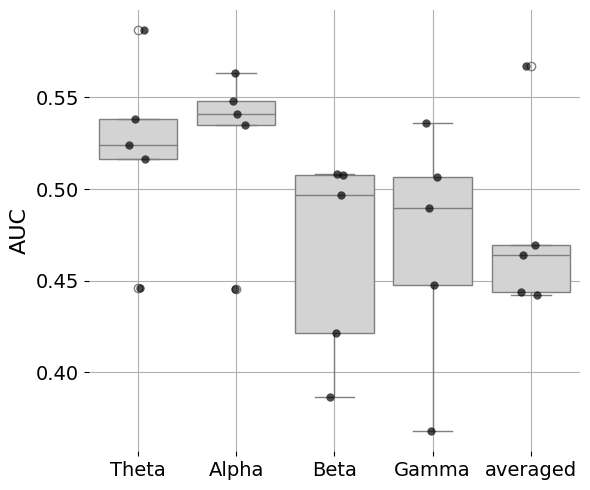

In [10]:
box_plot_auc(aucs, save_path=pics_dir)


In [ ]:
aucs.mean()

# Scatter plot of Z-scores for patients

In [ ]:
with open(os.path.join(processing_dir, "Z_clinicalpredict.pkl"), "rb") as file:
    z_patient = pickle.load(file)

z_patient.index = data_patient.index[:len(z_patient)]
#z_patient.index = data_patient.index
z_patient.columns = biomarker_names


z_scores_scatter_plot(X = list(z_patient.loc[:, "Adjusted_Canonical_Relative_PowerTheta_all"]),
                    Y = list(z_patient.loc[:, "Adjusted_Canonical_Relative_PowerBeta_all"]),
                    bands_name=["theta", "beta"], 
                    thr=0.68,
                    save_path=pics_dir)

# INOCS

In [ ]:
! pip install -U kaleido

In [ ]:
q_path = f"/home/{username}/Results/{project}/NM/Run_0/hetero_SHASH_bspline/Quantiles_estimate.pkl"

sub_index = "sub-87974617"
statistics = cal_stats_for_gauge(q_path, biomarker_names, 
                                 site_id=merged_data.loc[sub_index]["site"], 
                                 gender_id=merged_data.loc[sub_index]["sex"], 
                                 age=merged_data.loc[sub_index]["age"]*100)

new_names = ["Theta", "Theta", "Theta", "Theta", "Theta",
             "Alpha", "Alpha", "Alpha",  "Alpha","Alpha", 
             "Beta", "Beta", "Beta", "Beta", "Beta",
             "Gamma", "Gamma", "Gamma", "Gamma", "Gamma"]

for i, name in enumerate(biomarker_names):

    if new_names[i] == "Gamma": max_value=0.2
    else: max_value=1

    plot_quantile_gauge(merged_data.loc[sub_index, name],
                        statistics[name][1],
                        statistics[name][3],
                        statistics[name][0],
                        statistics[name][4],
                        statistics[name][2],
                        title="",
                        max_value=max_value,
                        show_legend=False,
                        bio_name=new_names[i],
                        save_path=pics_dir
                        )